In [1]:
import pandas as pd
import os
import numpy as np
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModel, 
    BertPreTrainedModel, 
    TrainingArguments, 
    Trainer
)
from transformers.modeling_outputs import SequenceClassifierOutput
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import accelerate
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

tqdm.pandas()

# --- 1. GPUの確認 ---
if torch.cuda.is_available():
    print(f"✅ GPU is available. Device: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("⚠️ GPU not found. Running on CPU.")
    device = torch.device("cpu")

✅ GPU is available. Device: NVIDIA GeForce RTX 3080 Ti


In [2]:
# --- 2. 設定 ---

TRAINING_FILE = "data/processed/training_dataset_abstract_cleaned_v3.csv"
MODEL_CHECKPOINT = "allenai/scibert_scivocab_uncased"

# --- 実験計画からのパラメータ ---
MAX_LENGTH = 512
LEARNING_RATE = 2e-5
TRIPLET_MARGIN = 1.0  # ▼▼▼ 修正点: マージンを1.0に設定 ▼▼▼

# --- ドライラン用の設定 ---
OUTPUT_MODEL_DIR = "models/sbert_triplet_DRYRUN"
# (Tripletは3つの入力を処理するため、Contrastiveよりバッチサイズを小さくします)
DRY_RUN_BATCH_SIZE = 2
EPOCHS = 1
DRY_RUN_SUBSET_FRAC = 0.01 # データの1%だけを使用

print("Configuration set for Triplet Loss DRY RUN.")

Configuration set for Triplet Loss DRY RUN.


In [3]:
# --- 3. カスタムモデルクラスの定義 (CLS Pooling) ---

class SiameseTripletModel(BertPreTrainedModel):
    """
    S-BERT (Triplet) モデル
    3つの入力を受け取り、3つのベクトルを出力する
    """
    def __init__(self, config):
        super(SiameseTripletModel, self).__init__(config)
        self.bert = AutoModel.from_config(config)
        self.init_weights()

    # ▼▼▼ 修正点: 'anchor' の引数名を変更 ▼▼▼
    # (input_ids_anchor -> input_ids, attention_mask_anchor -> attention_mask)
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        input_ids_positive=None,
        attention_mask_positive=None,
        input_ids_negative=None,
        attention_mask_negative=None,
        labels=None,
        **kwargs
    ):
        # ▼▼▼ 修正点: 'anchor' の引数名を変更 ▼▼▼
        output_anchor = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output_positive = self.bert(input_ids=input_ids_positive, attention_mask=attention_mask_positive)
        output_negative = self.bert(input_ids=input_ids_negative, attention_mask=attention_mask_negative)

        # CLSトークンのベクトルを取得
        vec_anchor = output_anchor.pooler_output
        vec_positive = output_positive.pooler_output
        vec_negative = output_negative.pooler_output

        return SequenceClassifierOutput(
            loss=None,
            logits=(vec_anchor, vec_positive, vec_negative),
            hidden_states=None,
            attentions=None,
        )

print("Custom model class 'SiameseTripletModel' (CLS Pooling) defined.")

Custom model class 'SiameseTripletModel' (CLS Pooling) defined.


In [4]:
# --- 4. データセットの読み込みとTripletへの変換 ---
print(f"Loading dataset: {TRAINING_FILE}")
df_full = pd.read_csv(TRAINING_FILE)
df_full = df_full.dropna(subset=['abstract_a', 'abstract_b', 'label'])
df_full['label'] = df_full['label'].astype(int)
print(f"Full dataset size: {len(df_full)}")

# ▼▼▼ ドライラン用に1%のサブセットをサンプリング ▼▼▼
df = df_full.sample(frac=DRY_RUN_SUBSET_FRAC, random_state=42)
print(f"Using {len(df)} pairs for dry run ({DRY_RUN_SUBSET_FRAC*100}%)")

pos_df = df[df['label'] == 1]
neg_df = df[df['label'] == 0]

if pos_df.empty or neg_df.empty:
    raise ValueError("Dry run subset does not contain both positive and negative samples.")

# --- Tripletの作成 ---
triplets = []
negative_abstracts = neg_df['abstract_b'].tolist()
if not negative_abstracts: # 負例がなかった場合のフォールバック
    negative_abstracts = pos_df['abstract_b'].tolist()

for index, row in pos_df.iterrows():
    anchor = row['abstract_a']
    positive = row['abstract_b']
    negative = np.random.choice(negative_abstracts)
    
    triplets.append({
        'anchor': anchor,
        'positive': positive,
        'negative': negative
    })

df_triplets = pd.DataFrame(triplets)

# ▼▼▼ 修正点: Trainerの評価ループを動作させるため、ダミーのlabels列を追加 ▼▼▼
# (TripletLoss自体はこの 'labels' を使用しません)
df_triplets['labels'] = 0

print(f"Created {len(df_triplets)} triplets for the dry run.")

# Triplet形式のデータセットをHugging Face形式に変換
raw_dataset = Dataset.from_pandas(df_triplets)
dataset_split = raw_dataset.train_test_split(test_size=0.2, seed=42)
dataset = DatasetDict({
    'train': dataset_split['train'],
    'validation': dataset_split['test']
})
print(f"Triplet dataset loaded: {dataset}")

Loading dataset: data/processed/training_dataset_abstract_cleaned_v3.csv
Full dataset size: 34624
Using 346 pairs for dry run (1.0%)
Created 67 triplets for the dry run.
Triplet dataset loaded: DatasetDict({
    train: Dataset({
        features: ['anchor', 'positive', 'negative', 'labels'],
        num_rows: 53
    })
    validation: Dataset({
        features: ['anchor', 'positive', 'negative', 'labels'],
        num_rows: 14
    })
})


In [5]:
# --- 5. トークナイズ処理 (Triplet用) ---
print("Initializing tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_triplet_function(examples):
    # Anchor, Positive, Negative の3つを別々にトークン化
    tokenized_anchor = tokenizer(examples["anchor"], padding="max_length", truncation=True, max_length=MAX_LENGTH)
    tokenized_positive = tokenizer(examples["positive"], padding="max_length", truncation=True, max_length=MAX_LENGTH)
    tokenized_negative = tokenizer(examples["negative"], padding="max_length", truncation=True, max_length=MAX_LENGTH)
    
    # ▼▼▼ 修正点: 'anchor' のキー名を変更 ▼▼▼
    # ("input_ids_anchor" -> "input_ids", "attention_mask_anchor" -> "attention_mask")
    return {
        "input_ids": tokenized_anchor["input_ids"],
        "attention_mask": tokenized_anchor["attention_mask"],
        "input_ids_positive": tokenized_positive["input_ids"],
        "attention_mask_positive": tokenized_positive["attention_mask"],
        "input_ids_negative": tokenized_negative["input_ids"],
        "attention_mask_negative": tokenized_negative["attention_mask"],
    }

print("Tokenizing triplet dataset...")
tokenized_datasets = dataset.map(tokenize_triplet_function, batched=True, num_proc=2,
                                 remove_columns=["anchor", "positive", "negative"])
tokenized_datasets.set_format("torch")
print("Tokenization complete.")

Initializing tokenizer...


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenizing triplet dataset...


Map (num_proc=2):   0%|          | 0/53 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/14 [00:00<?, ? examples/s]

Tokenization complete.


In [6]:
# --- 6. カスタムTrainerの定義 ---

class TripletTrainer(Trainer):
    """
    TripletLossを計算するためにTrainerを継承
    """
    def __init__(self, *args, margin=1.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.margin = margin
        # PyTorch組み込みのTripletLossを使用
        self.loss_fct = nn.TripletMarginLoss(margin=self.margin)
        print(f"TripletTrainer initialized with margin={self.margin}")

    def compute_loss(self, model, inputs, return_outputs=False):
        # 'labels' はこの損失では使われない
        if "labels" in inputs:
            inputs.pop("labels")
            
        # モデルのforwardパスを実行（3つのベクトルがlogitsとして返ってくる）
        outputs = model(**inputs)
        vec_anchor, vec_positive, vec_negative = outputs.logits
        
        # 損失の計算
        loss = self.loss_fct(vec_anchor, vec_positive, vec_negative)

        return (loss, outputs) if return_outputs else loss

print("Custom 'TripletTrainer' defined.")

Custom 'TripletTrainer' defined.


In [7]:
# --- 7. モデルのロードと訓練設定 ---
print(f"Loading custom model: {MODEL_CHECKPOINT}")
# modelクラスをSiameseTripletModelに変更
model = SiameseTripletModel.from_pretrained(MODEL_CHECKPOINT).to(device)
print("Custom model loaded.")

# 評価指標を計算する関数 (Triplet Accuracy)
def compute_metrics_triplet(eval_pred):
    # eval_pred.predictions は (vec_a, vec_p, vec_n) のタプル
    vec_a, vec_p, vec_n = eval_pred.predictions
    
    # 距離を計算 (Eucledian distance)
    dist_pos = F.pairwise_distance(torch.tensor(vec_a), torch.tensor(vec_p))
    dist_neg = F.pairwise_distance(torch.tensor(vec_a), torch.tensor(vec_n))
    
    # 成功 =  positiveとの距離がnegativeとの距離より「小さい」
    accuracy = (dist_pos < dist_neg).float().mean().item()
    
    return {'triplet_accuracy': accuracy}

# 訓練の設定
training_args = TrainingArguments(
    output_dir=OUTPUT_MODEL_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=DRY_RUN_BATCH_SIZE,
    per_device_eval_batch_size=DRY_RUN_BATCH_SIZE,
    num_train_epochs=EPOCHS, # 1エポック
    weight_decay=0.01,
    evaluation_strategy="steps",
    eval_steps=10,
    save_strategy="no",
    load_best_model_at_end=False,
    logging_steps=1,
    warmup_ratio=0.1,
)
print("Training arguments set for DRY RUN.")

Loading custom model: allenai/scibert_scivocab_uncased
Custom model loaded.
Training arguments set for DRY RUN.


In [8]:
# --- 8. 訓練の開始 ---
trainer = TripletTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_triplet, # ★専用メトリクスに変更
    margin=TRIPLET_MARGIN
)

print("\n--- Starting Model Training (Triplet Loss DRY RUN) ---")
trainer.train()
print("--- Model Training Complete ---")

TripletTrainer initialized with margin=1.0

--- Starting Model Training (Triplet Loss DRY RUN) ---


Step,Training Loss,Validation Loss,Triplet Accuracy
10,1.444200,1.100458,0.642857
20,0.368700,0.440401,0.785714


--- Model Training Complete ---



--- Visualizing Training Results ---


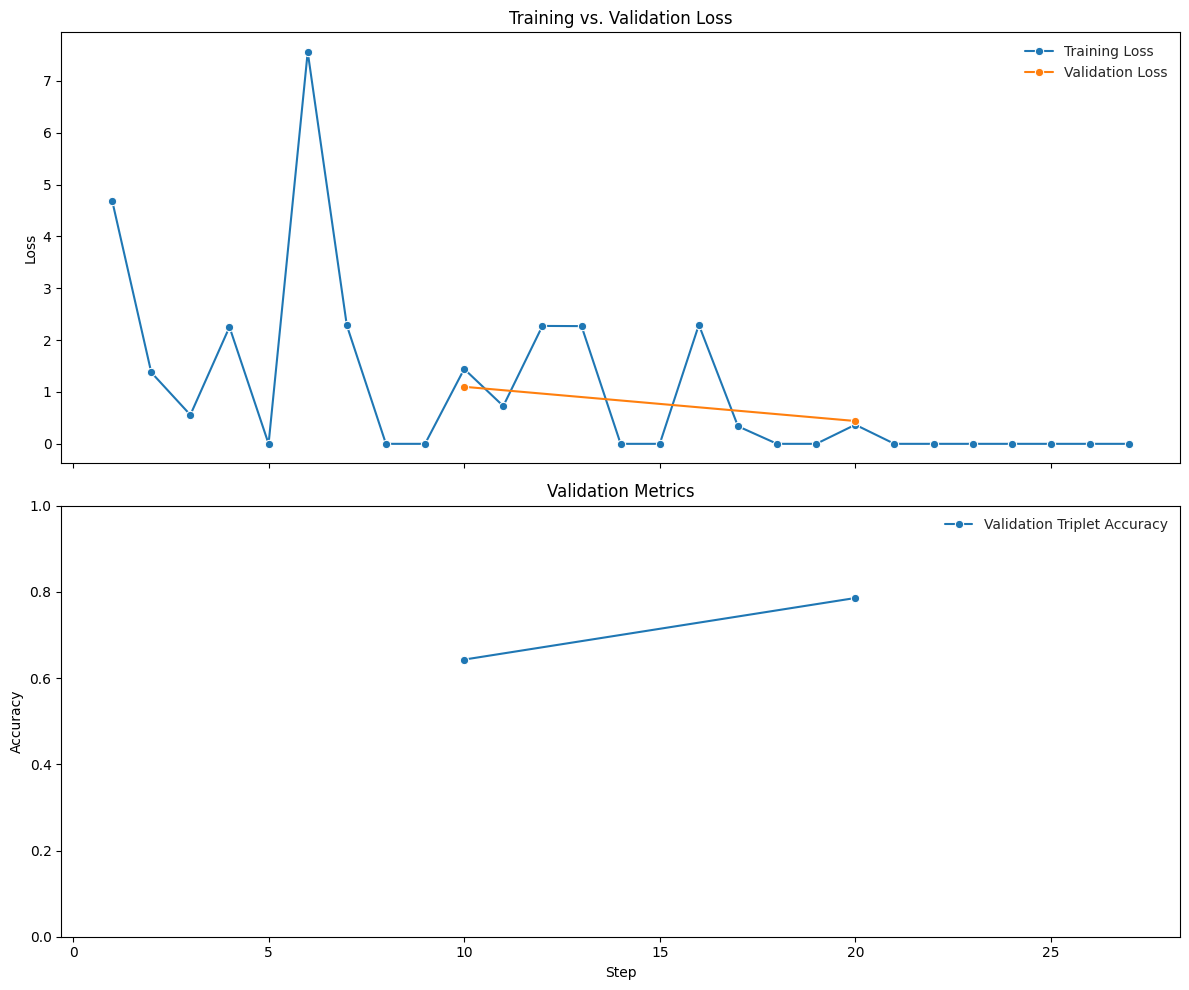


--- Best Model Evaluation Metrics (from validation set) ---
Best Step (based on min eval_loss): 20.0
Best Validation Loss: 0.4404
Best Validation Triplet Accuracy: 0.7857


In [9]:
# --- 9. 訓練結果の可視化 ---
print("\n--- Visualizing Training Results ---")
log_history = trainer.state.log_history
df_log = pd.DataFrame(log_history)

df_train = df_log[df_log['loss'].notna()].copy()
df_eval = df_log[df_log['eval_loss'].notna()].copy() # 訓練が成功すれば、今度はこの行が通るはず

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.style.use('seaborn-v0_8-whitegrid')

if not df_train.empty:
    sns.lineplot(data=df_train, x='step', y='loss', label='Training Loss', ax=ax1, marker='o')
if not df_eval.empty:
    sns.lineplot(data=df_eval, x='step', y='eval_loss', label='Validation Loss', ax=ax1, marker='o')
ax1.set_title('Training vs. Validation Loss')
ax1.set_ylabel('Loss')
ax1.legend()

# ▼▼▼ 修正点: 'eval_f1' ではなく 'eval_triplet_accuracy' をプロット ▼▼▼
if not df_eval.empty:
    sns.lineplot(data=df_eval, x='step', y='eval_triplet_accuracy', label='Validation Triplet Accuracy', ax=ax2, marker='o')
ax2.set_title('Validation Metrics')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Step')
ax2.legend()
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# ▼▼▼ 修正点: 参照するメトリクス名を変更 ▼▼▼
print("\n--- Best Model Evaluation Metrics (from validation set) ---")
if not df_eval.empty:
    best_run = df_eval.loc[df_eval['eval_loss'].idxmin()]
    print(f"Best Step (based on min eval_loss): {best_run['step']}")
    print(f"Best Validation Loss: {best_run['eval_loss']:.4f}")
    print(f"Best Validation Triplet Accuracy: {best_run['eval_triplet_accuracy']:.4f}")
else:
    print("No evaluation steps were completed.")